<a href="https://colab.research.google.com/github/EsbenUrbak/Airbnb/blob/master/London_Airbnb_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Introduction

The why?:
Are you about to put your London property up for rent on Airbnb? Maybe you are wondering when during the year is best? What are the most important features of your house to highlight and how much should you charge for your property? 

In order to address the above "business" situation, I took a look at the Airbnb London dataset and specifically answered the following 3 questions:
1. When during the year is it most likely to get your Airbnb property rented out and which months/days can you charge more
2. How much can you charge for your property?
3. What features of your house should you highlight in order to maximize the rental price you can charge?

# Section 1. Loading libraries and gather the necessary data:

Loading the libraries used in this notebook:

In [15]:
# For some of the outputs colab will show irrelevant warnings so the below 2 lines will supress this for ease of reading this book.
import warnings
warnings.filterwarnings('ignore')

#Loading the necessary libraries
#Data handling libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

#stats library
from scipy import stats

#plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Modelling libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor

Gathering the data to be  analysed:

In [16]:
#London Airbnb Data raw links (using data prior to pandemic to get a "normal times" picture)
url_listings = "http://data.insideairbnb.com/united-kingdom/england/london/2020-11-06/data/listings.csv.gz"
url_reviews = "http://data.insideairbnb.com/united-kingdom/england/london/2018-11-04/data/reviews.csv.gz"
url_calendar = "http://data.insideairbnb.com/united-kingdom/england/london/2018-11-04/data/calendar.csv.gz"

#reading the data into pandas
df_listings = pd.read_csv(url_listings)
df_calendar = pd.read_csv(url_calendar)
#df_reviews = pd.read_csv(url_reviews)

# Section 2. Airbnb calendar data

## Data Understanding

In [27]:
#Inspecting the data
df_calendar.describe(include="all")

,listing_id,date,available,price
count,2.730748e+07,27307475,27307475,9.248255e+06
unique,NaN,368,2,NaN
top,NaN,2019-07-12 00:00:00,f,NaN
freq,NaN,74815,18059220,NaN
first,NaN,2018-11-04 00:00:00,NaN,NaN
last,NaN,2019-11-06 00:00:00,NaN,NaN
mean,1.767883e+07,NaN,NaN,1.364891e+02
std,8.350850e+06,NaN,NaN,2.908197e+02
min,9.554000e+03,NaN,NaN,7.000000e+00
25%,1.137763e+07,NaN,NaN,4.800000e+01


##Preparing the data: cleaning the calendar data 

In [17]:
#Cleaning the data
#Converting the price into a float number instead of a $ string
df_calendar['price'] = df_calendar['price'].str.replace(',', '')
df_calendar['price'] = df_calendar['price'].str.replace('$', '')
df_calendar['price'] = df_calendar['price'].astype(float)
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

,listing_id,date,available,price
count,2.730748e+07,27307475,27307475,9.248255e+06
unique,NaN,368,2,NaN
top,NaN,2019-07-12 00:00:00,f,NaN
freq,NaN,74815,18059220,NaN
first,NaN,2018-11-04 00:00:00,NaN,NaN
last,NaN,2019-11-06 00:00:00,NaN,NaN
mean,1.767883e+07,NaN,NaN,1.364891e+02
std,8.350850e+06,NaN,NaN,2.908197e+02
min,9.554000e+03,NaN,NaN,7.000000e+00
25%,1.137763e+07,NaN,NaN,4.800000e+01


## Calendar availability

###Data Modelling 
Analyzing and modelling the cleaned calendar data inorder to get insight into the availability during the year:

In [18]:
# Looking at the availability of the calendar to see when might be the best time to rent out a property in London
calendar_new = df_calendar[['date', 'available']]
#Find where it is busy(1) and when it is free (0) 
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == 't' else 1)
#Then group by date and take the mean of "busy" (if the mean = 1 then that means none are free)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()

### Evaluating the results
Visualising the results: Here showing the %free throughout the year

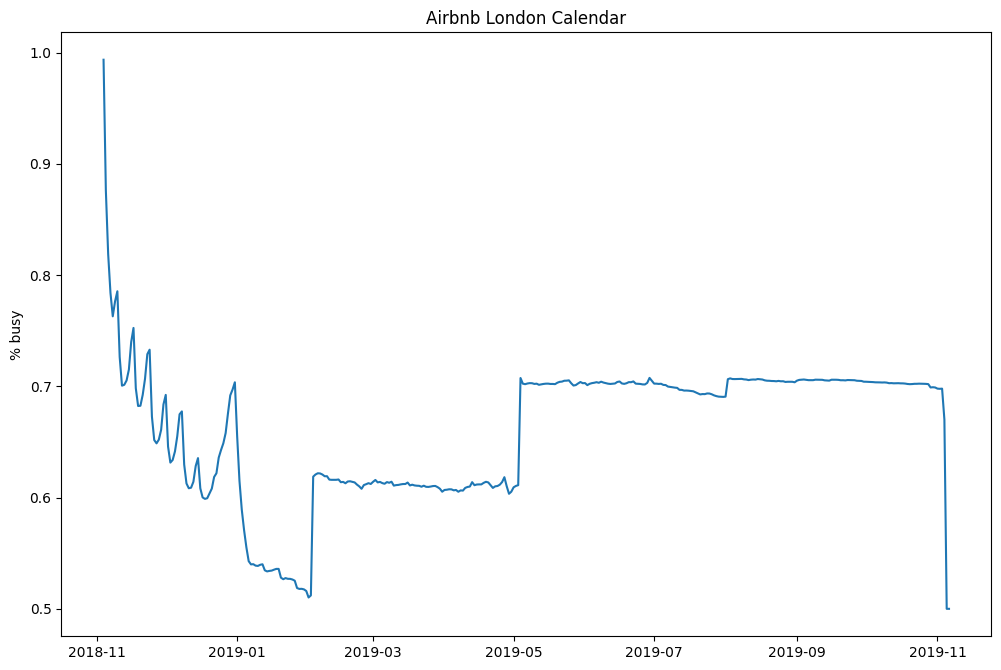

In [19]:
#Plotting it versus dates
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb London Calendar')
plt.ylabel('% busy')
plt.show();

## Cost by month

### Data Modelling
Analyzing and modelling the cleaned calendar data inorder to get insight into the mean cost per month during the year:

In [20]:
#Looking at the mean rental price per month to see if there are any months might be more profitable
mean_of_month = df_calendar.groupby(df_calendar['date'].dt.strftime('%B'),sort=False)['price'].mean()
#Creating an array with the months
Months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
#Getting the mean prices for each month
mean_price = [mean_of_month["January"], mean_of_month["February"], mean_of_month["March"], mean_of_month["April"], mean_of_month["May"], mean_of_month["June"], mean_of_month["July"], mean_of_month["August"], mean_of_month["September"], mean_of_month["October"], mean_of_month["November"], mean_of_month["December"]]

###Evaluating the results
Visualising the results: Here showing the mean costs by calendar month

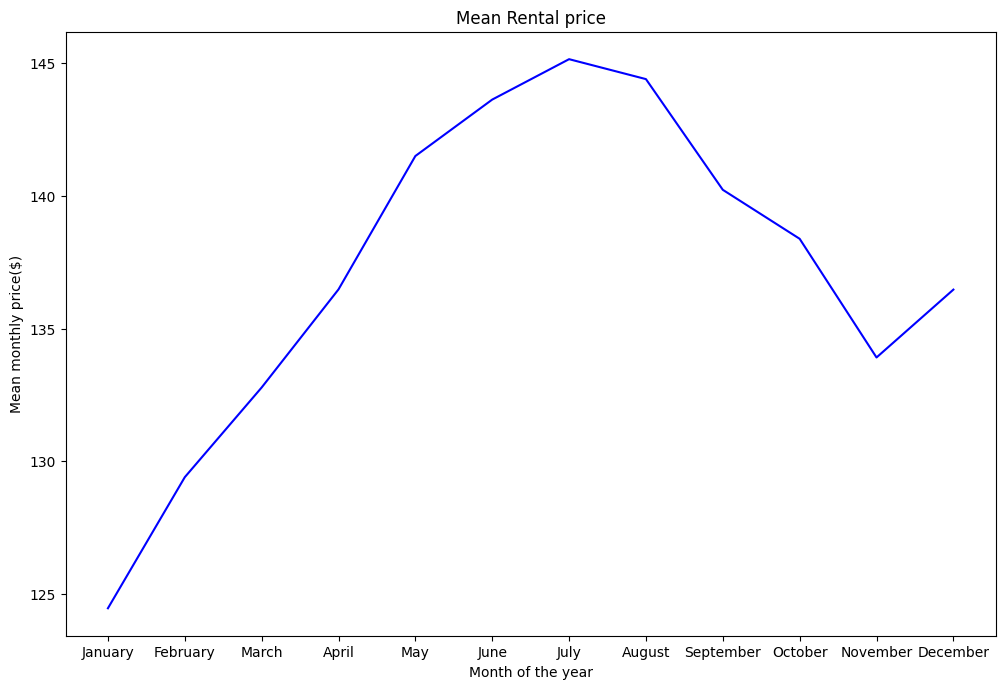

In [21]:
#plotting the mean price vs month:
Months_pos = [i for i, _ in enumerate(Months)]
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(Months_pos, mean_price, color='Blue')
plt.xlabel("Month of the year")
plt.ylabel('Mean monthly price($)');
plt.title("Mean Rental price")
plt.xticks(Months_pos, Months)
plt.show()

## Cost by weekday

### Data Modelling
Analyzing and modelling the cleaned calendar data inorder to get insight into the mean cost per weekday:

In [22]:
#Looking at the mean rental price by weekday to see if there are any days that might be more profitable
mean_of_day = df_calendar.groupby(df_calendar['date'].dt.dayofweek,sort=False)['price'].mean()
#Creating an array with the days
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Satuday", "Sunday"]
#Getting the mean prices for each day
mean_price = [mean_of_day[0], mean_of_day[1], mean_of_day[2], mean_of_day[3], mean_of_day[4], mean_of_day[5], mean_of_day[6]]


### Evaluating the results
Visualising the results: Here showing the mean by weekday


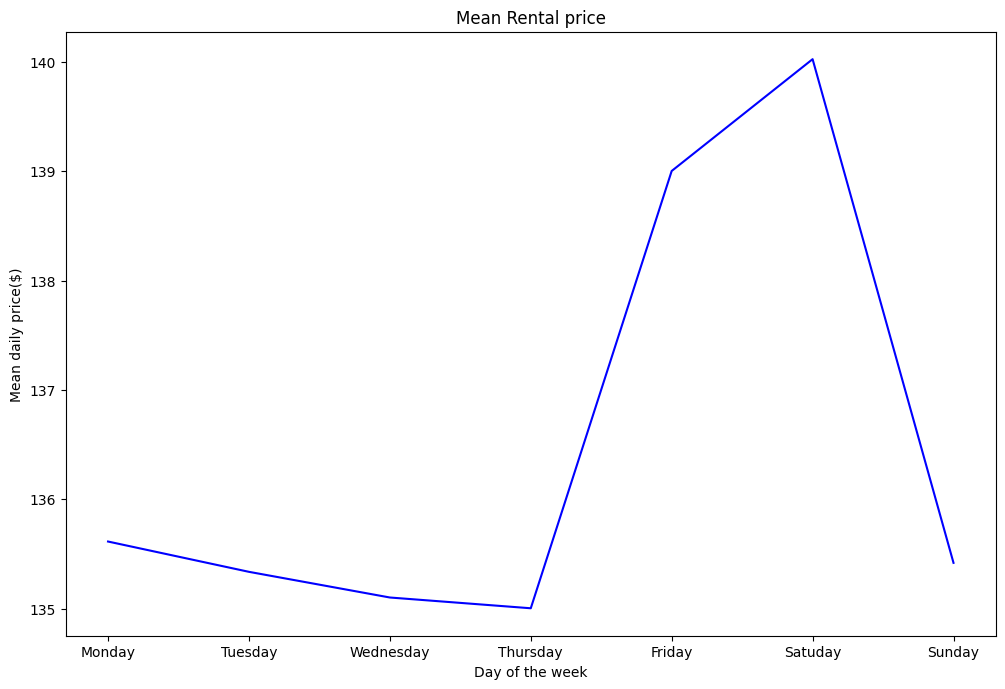

In [23]:
#Plotting the price vs week day
days_pos = [i for i, _ in enumerate(days)]
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(days_pos, mean_price, color='Blue')
plt.xlabel("Day of the week")
plt.ylabel('Mean daily price($)');
plt.title("Mean Rental price")
plt.xticks(days_pos, days)
plt.show()

# Section 3. The Airbnb Listing data

## Data Understanding

In [28]:
#Having a look at the listings data:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201106040109,2020-11-07,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Cable TV"", ""Coffee maker"", ""Carbon monoxide ...",$97.00,7,190,7,28,1125,1125,8.4,1125.0,NaN,t,0,0,4,279,2020-11-07,192,7,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.48
1,13913,https://www.airbnb.com/rooms/13913,20201106040109,2020-11-07,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a day,83%,71%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Cable TV"", ""Bed linens"", ""Coffee maker"", ""Pa...",$40.00,1,29,1,28,29,29,2.8,29.0,NaN,t,30,60,90,365,2020-11-07,21,2,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201106040109,2020-11-07,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within a day,100%,100%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Cable TV"", ""Coffee maker"", ""Dryer"", ""Dishes ...",$75.00,10,50,10,28,50,50,11.2,50.0,NaN,t,0,20,50,150,20

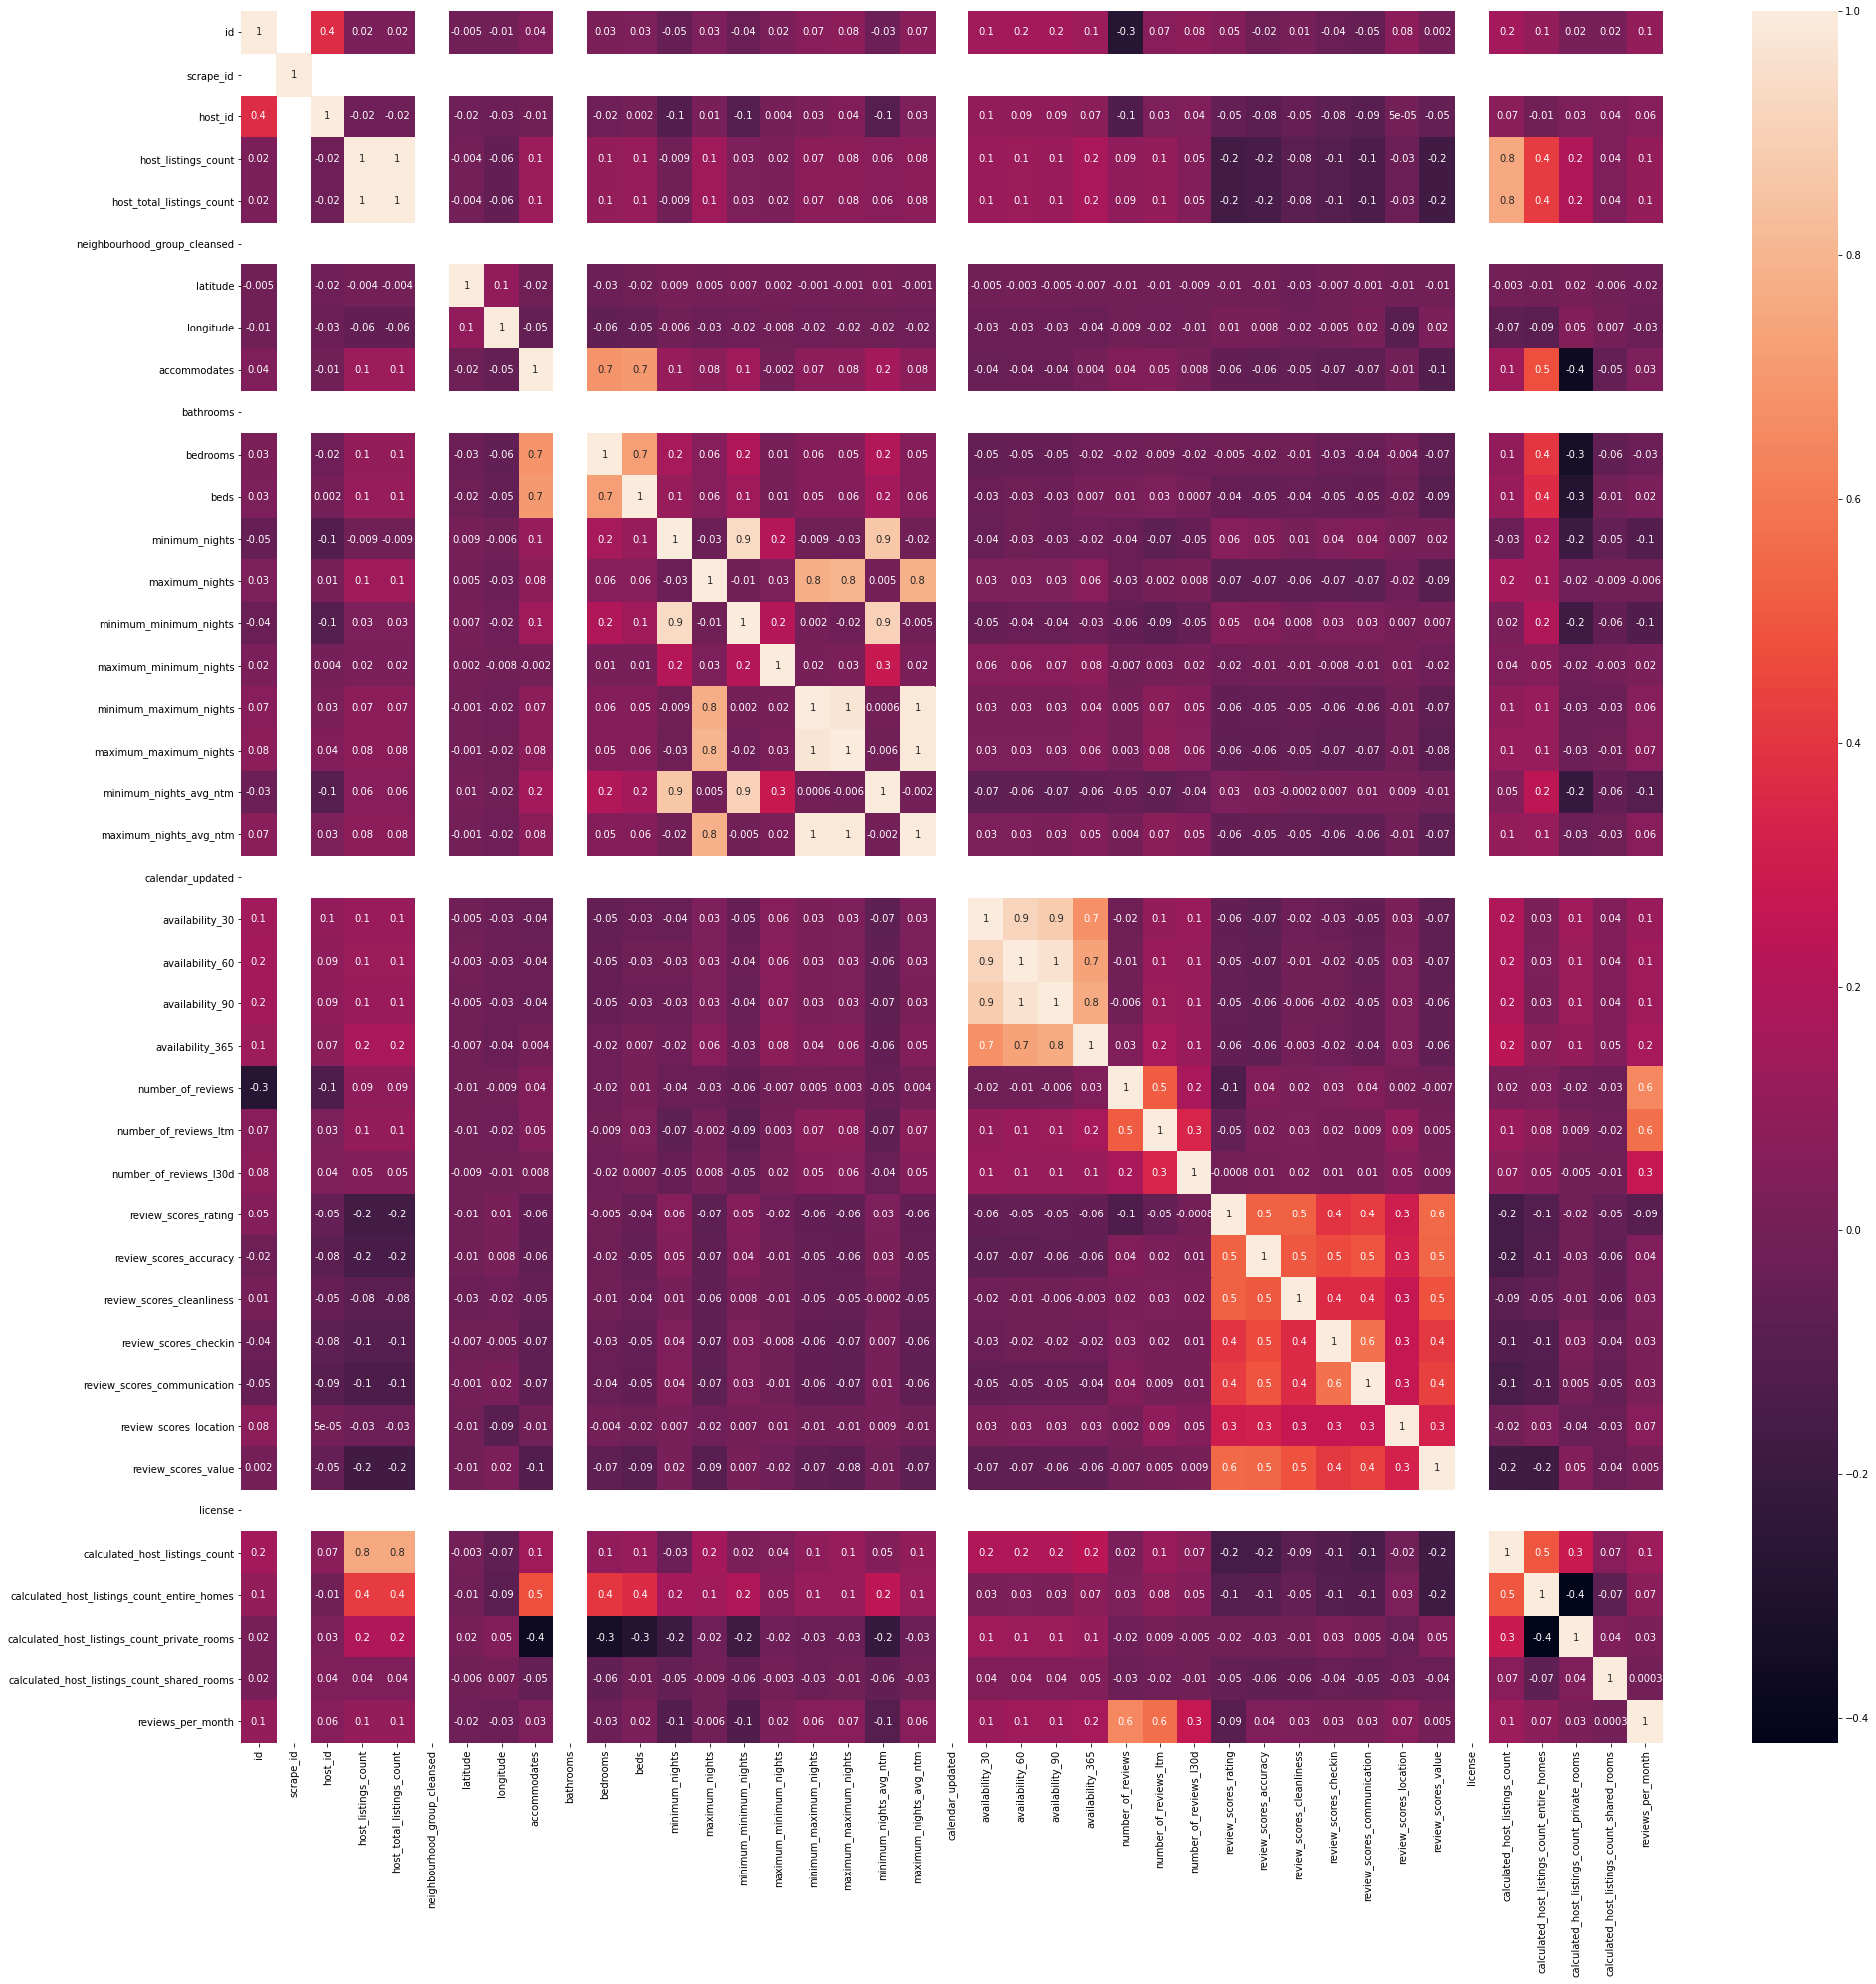

In [29]:
#lets first look at the correlation of the full set to see if there is anything that stands out: (though due to the number of variables this is rather less useful)
corr = df_listings.corr(method = "kendall")
plt.figure(figsize=(32,32))
sns.heatmap(corr, annot=True, fmt='0.1g')

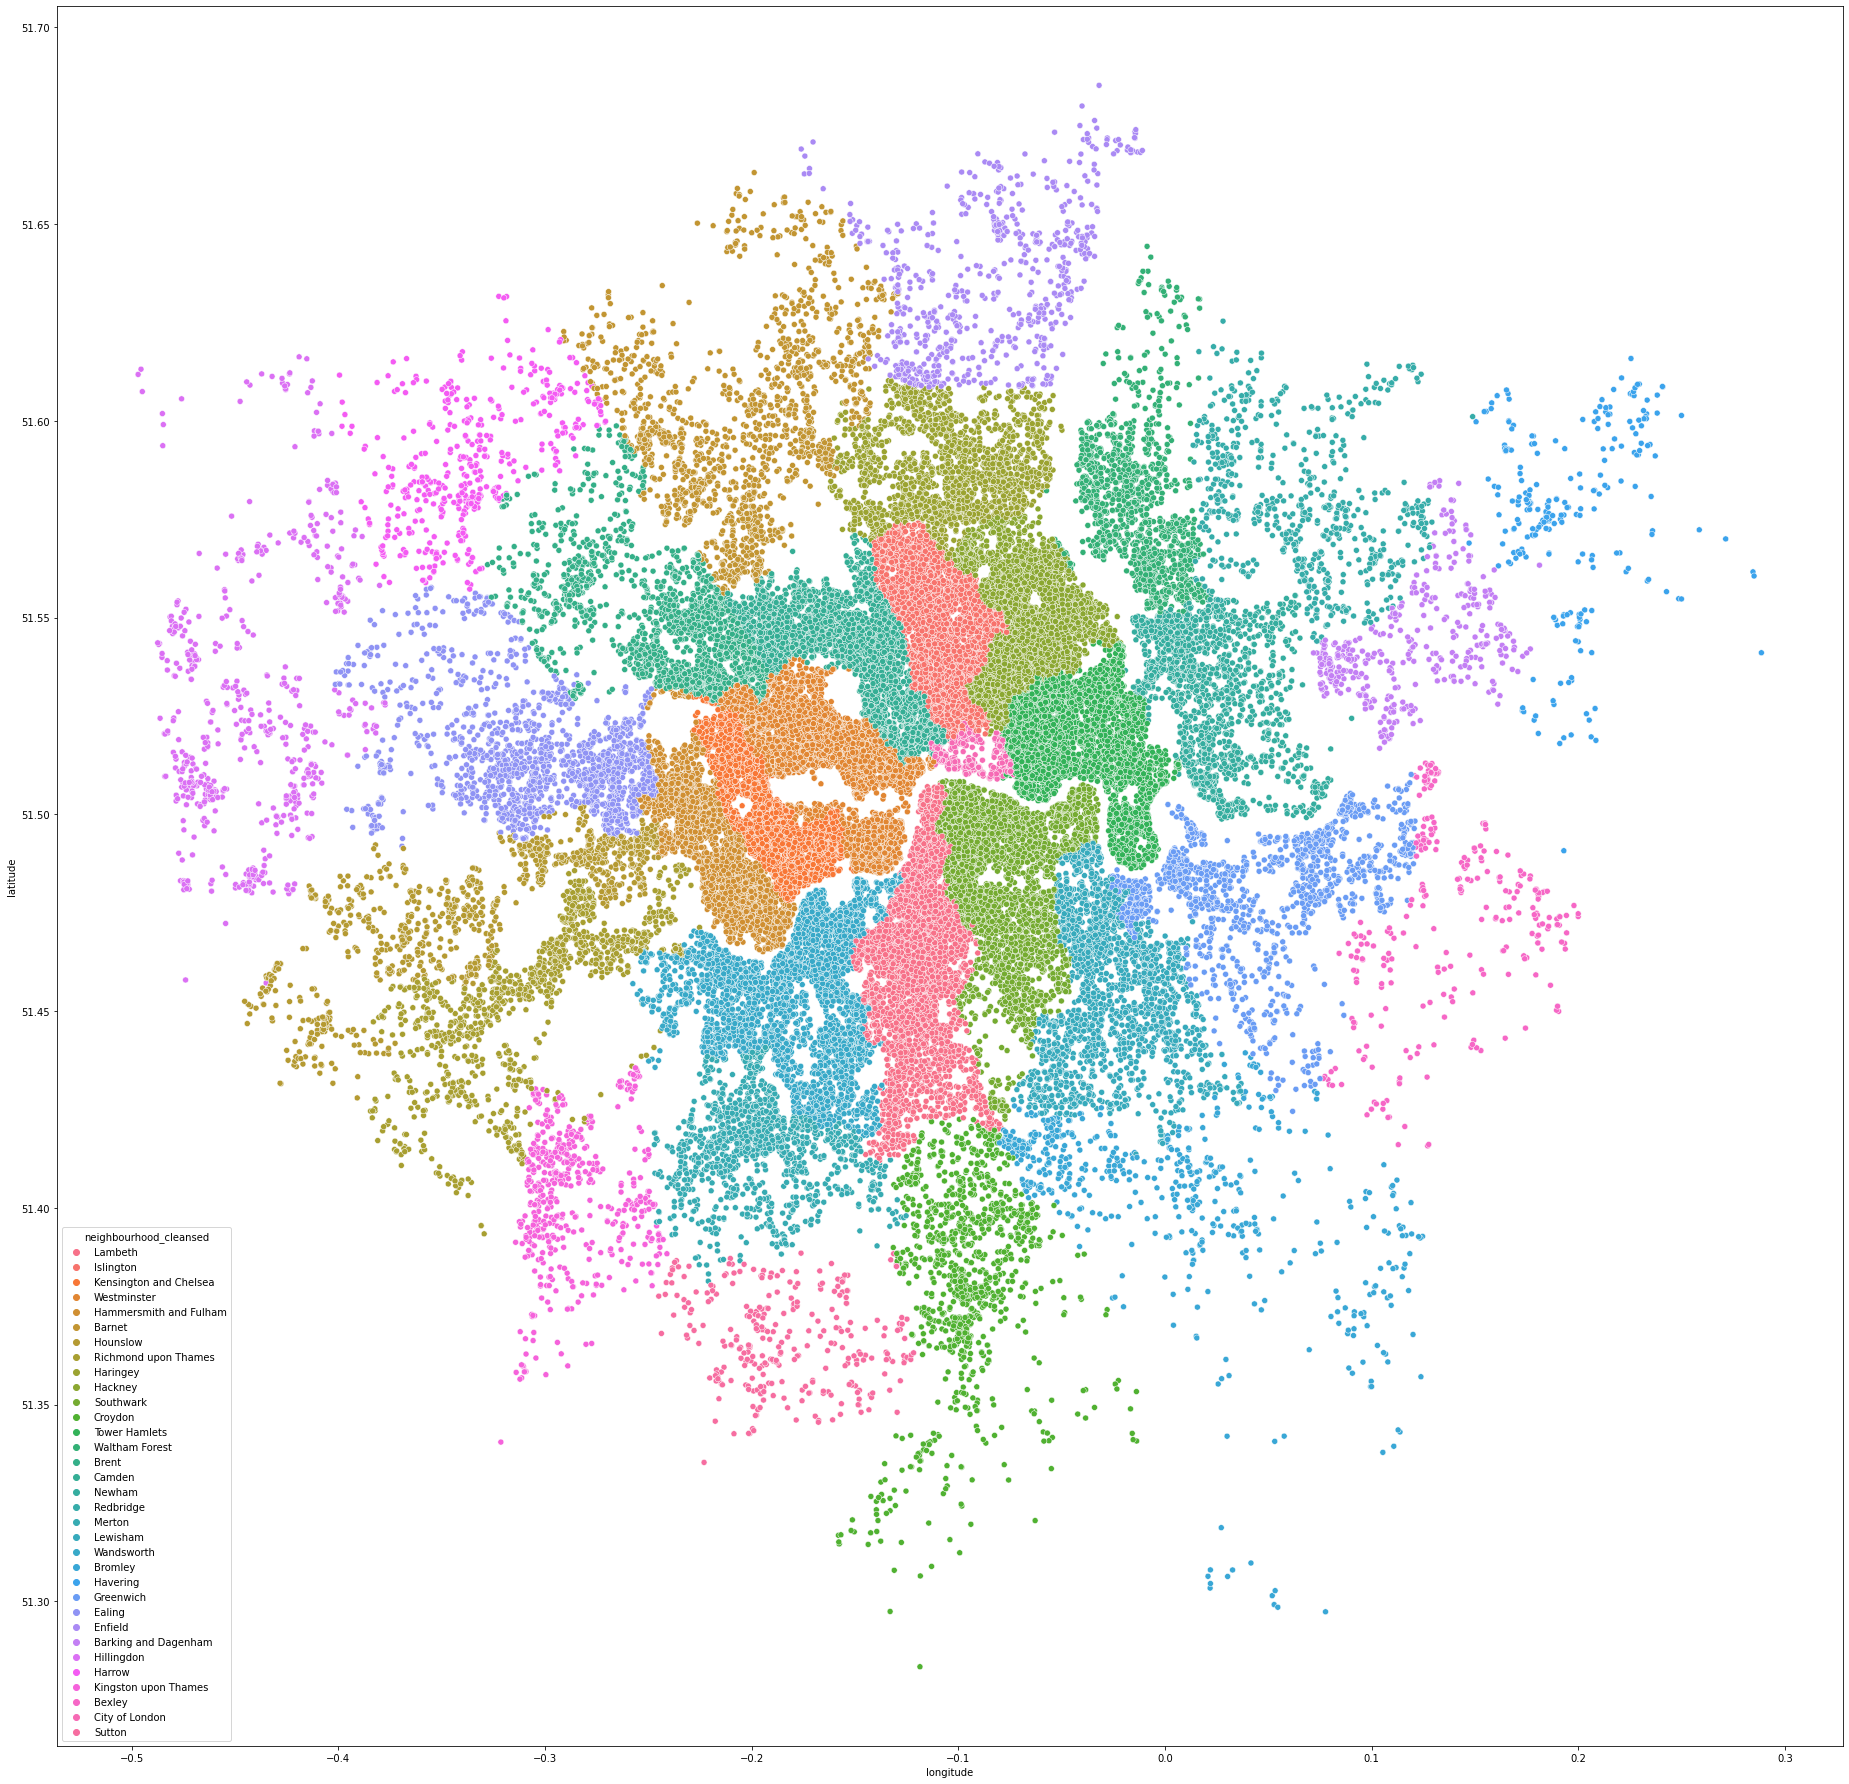

In [30]:
# since we have longitude and laditude lets look at a map of where the listings are:
plot_dims = (32,32)
plt.figure(figsize=plot_dims)
sns.scatterplot(df_listings.longitude, df_listings.latitude,hue=df_listings.neighbourhood_cleansed)
plt.ioff()

## Preparing the data: Cleaning the data

In [31]:
#Reducing the data set to the columns of interest and in my opinion would affect the value the most
columns_listing_features = df_listings[["price","review_scores_rating","neighbourhood_cleansed","property_type","accommodates","bathrooms_text","bedrooms","beds","minimum_nights","maximum_nights","instant_bookable"]]

In [32]:
############### CLEANING THE DATA ########

############### Bath Room #################
#convert price into a numerical value:
columns_listing_features[columns_listing_features.columns[0:1]] = columns_listing_features[columns_listing_features.columns[0:1]].replace('[\$,]', '', regex=True).astype(float)

############### Bath Room #################
#Aligning bath room words to simply regression later
columns_listing_features["bathrooms_text"]=columns_listing_features["bathrooms_text"].replace(np.nan,"0 baths");
columns_listing_features["bathrooms_text"]=columns_listing_features["bathrooms_text"].replace("Half-bath","0.5 baths");
columns_listing_features["bathrooms_text"]=columns_listing_features["bathrooms_text"].replace("Shared half-bath","0.5 shared baths");
columns_listing_features["bathrooms_text"]=columns_listing_features["bathrooms_text"].replace("Private half-bath","0.5 baths");
columns_listing_features["bathrooms_text"]=columns_listing_features["bathrooms_text"].replace("1 private bath","1 baths");
columns_listing_features["bathrooms_text"]=columns_listing_features["bathrooms_text"].replace("1 shared bath","1 shared baths");
columns_listing_features["bathrooms_text"]=columns_listing_features["bathrooms_text"].replace("1 bath","1 baths");
#convert bath rooms into simple numerical and a type:
columns_listing_features[["bathrooms_number","bathrooms_type"]] = columns_listing_features["bathrooms_text"].str.split(' ', expand=True, n=1)
columns_listing_features["bathrooms_number"]=columns_listing_features["bathrooms_number"].astype(float)
#Deleting the "old" bathroom column
del columns_listing_features['bathrooms_text']

############### Property Type #################
# proterty type classification: Entire place , private room, shared room, other
others_list=['Room in serviced apartment','Room in aparthotel','Tiny house','Campsite','Room in bed and breakfast','Boat','Camper/RV','Yurt','Room in boutique hotel','Houseboat','Earth house','Room in hostel','Barn','Room in hotel','Castle','Room in apartment','Casa particular','Hut','Room in minsu','Island','Lighthouse','Dome house']
columns_listing_features.property_type = columns_listing_features.property_type.apply(lambda x: 'Entire Place' if 'Entire' in x else x)
columns_listing_features.property_type = columns_listing_features.property_type.apply(lambda x: 'Private Room' if 'Private room' in x else x)
columns_listing_features.property_type = columns_listing_features.property_type.apply(lambda x: 'Shared Room' if 'Shared room' in x else x)
columns_listing_features = columns_listing_features.replace(others_list,"other")


############### Categorical -->> Dummies #################
# create dummy variables for all non numerical features
variables = ["neighbourhood_cleansed", "property_type","bathrooms_type", "instant_bookable"]
dummy = columns_listing_features[variables]
dummy = pd.get_dummies(data=dummy, drop_first=True)
#drop these coloumns from the original
only_numerical = columns_listing_features[columns_listing_features.columns.drop(variables)]
#mergin the dummy frame with the numerical frame:
features_final = pd.concat([only_numerical, dummy], axis=1)

#Checking what we now have:
features_final.describe(include="all")

,price,review_scores_rating,accommodates,bedrooms,beds,minimum_nights,maximum_nights,bathrooms_number,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Private Room,property_type_Shared Room,property_type_other,bathrooms_type_shared baths,instant_bookable_t
count,76984.000000,53494.000000,76984.000000,72238.000000,75904.000000,76984.000000,7.698400e+04,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000,76984.000000
mean,112.107932,93.104647,3.077393,1.487818,1.706814,5.142120,2.073861e+04,1.304070,0.021342,0.003546,0.030370,0.007521,0.068300,0.005832,0.014419,0.021732,0.008911,0.020589,0.074314,0.046464,0.027538,0.005858,0.003286,0.008158,0.013444,0.058311,0.069222,0.006664,0.057233,0.028240,0.016224,0.024096,0.009002,0.014743,0.056245,0.003923,0.088759,0.017822,0.051231,0.111400,0.427530,0.008067,0.018822,0.259599,0.401044
std,325.929453,10.369240,1.947671,0.884929,1.275783,22.477012,4.070647e+06,0.618953,0.144523,0.059445,0.171604,0.086398,0.252261,0.076147,0.119209,0.145807,0.093977,0.142004,0.262283,0.210490,0.163647,0.076316,0.057233,0.089951,0.115168,0.234332,0.253833,0.081360,0.232288,0.165658,0.126337,0.153348,0.094451,0.120524,0.230397,0.062510,0.284397,0.132305,0.220471,0.314629,0.494723,0.089452,0.135897,0.438418,0.490113
min,0.000000,20.000000,1.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.000000,90.000000,2.000000,1.000000,1.000000,1.000000,3.100000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75.000000,96.000000,2.000000,1.000000,1.000000,2.000000,1.125000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,121.000000,100.000000,4.0

REMOVING MISSING ROWS AND OUTLIERS

In [33]:
# cleaning the data - in this case it seem safe to simply remove rows with missing data as we will still have more than 70k data points
features_final = features_final.dropna()

## Preparing the data: Removing outliers

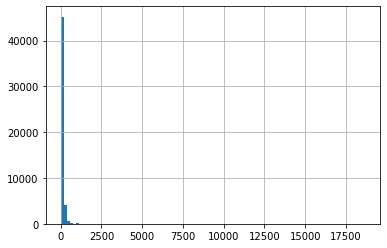

In [34]:
#Looking at the price data to see if there are any extreme values/outliers that will disturb our model
hist = features_final.price.hist(bins=100)

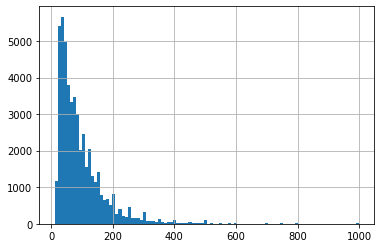

In [35]:
#removing extreme prices to make make predictions better (clearly most prices are well below 1000)
features_final_reduced = features_final[features_final['price'] < 1000] 
features_final_reduced = features_final_reduced[features_final_reduced['price'] > 10] 
hist = features_final_reduced.price.hist(bins=100)

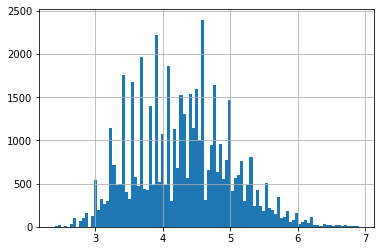

In [36]:
#this looks very much like a log function so converting the price data to that
features_final_reduced["price"]=np.log(features_final_reduced["price"])
hist = features_final_reduced.price.hist(bins=100)

Looking at each parameter against price to see if anything sticks out:

In [37]:
#_ = sns.pairplot(features_final_reduced, kind='reg', diag_kind='kde')
# Unfortunately, colab doesnt seem to have fast enough machine to generate all of these graphs at the same time

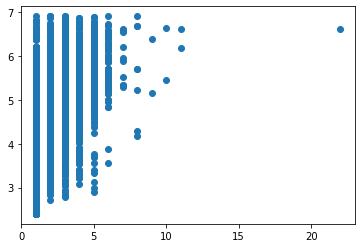

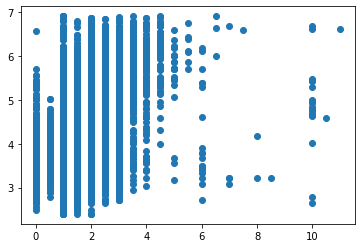

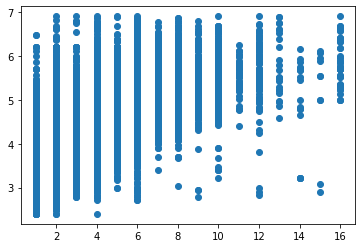

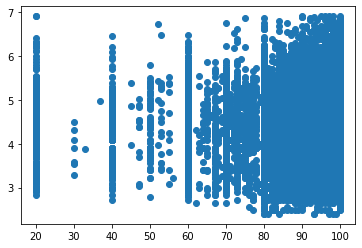

In [38]:
#plotting the data against price to see with the naked eye what migth be going on: (Nothing stands out)
plt.scatter(features_final_reduced.bedrooms, features_final_reduced.price)
plt.show()

plt.scatter(features_final_reduced.bathrooms_number, features_final_reduced.price)
plt.show()

plt.scatter(features_final_reduced.accommodates, features_final_reduced.price)
plt.show()

plt.scatter(features_final_reduced.review_scores_rating, features_final_reduced.price)
plt.show()

Cant find any more straight forward ways to eliminated outliers - see appendix for more methods tried 

## Data Modelling

In [39]:
#################### Random Forest Regressor  ####################
# This was the main model used (other models attempted can be found in the appendix)

#Split into explanatory and response variables
x_reduced = features_final_reduced.drop(['price',"maximum_nights","instant_bookable_t" ], axis=1)
y_reduced = features_final_reduced['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(x_reduced, y_reduced, test_size = .3, random_state=42) 

rf = RandomForestRegressor(n_estimators=100, criterion='mse', n_jobs=-1)

#fitting/training the model
rf.fit(X_train, y_train)
     
#Predict and score the model
y_test_preds_rf = rf.predict(X_test) 

#Printing the r sqaured of the model
print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds_rf), len(y_test)))

The r-squared score for the model using only quantitative variables was 0.6552233713432236 on 14985 values.


## Evaluating the results

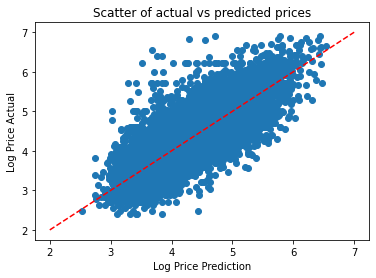

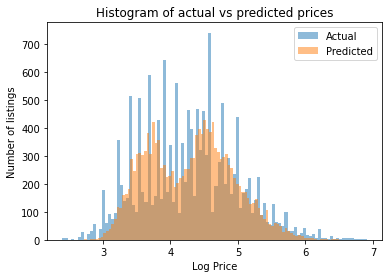

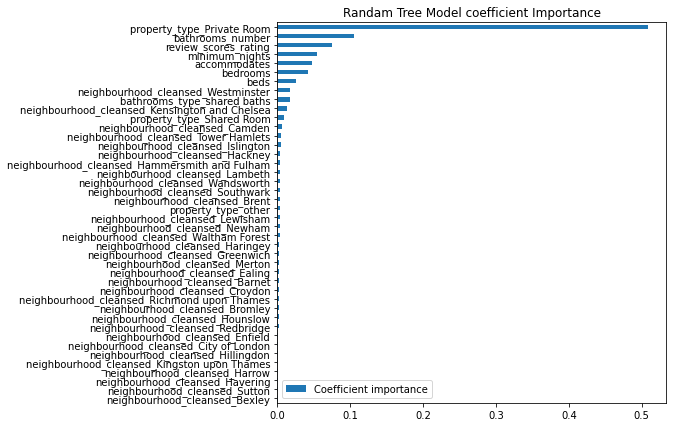

In [40]:
#scatter plot of the predict vs actual prices:
x_coordinates = [2, 3, 4,5,6,7]
plt.plot(x_coordinates, x_coordinates, color='red', ls="--")
plt.scatter(y_test_preds_rf,y_test)
plt.xlabel("Log Price Prediction")
plt.ylabel('Log Price Actual');
plt.title("Scatter of actual vs predicted prices")
plt.show()

#Histogram of actual vs predict prices
plt.hist(y_test, bins=100, alpha=0.5, label='Actual')
plt.hist(y_test_preds_rf, bins=100, alpha=0.5, label='Predicted')
plt.legend(loc='upper right')
plt.xlabel("Log Price")
plt.ylabel('Number of listings');
plt.title("Histogram of actual vs predicted prices")
plt.show()
plt.show()

# Plotting the "importance" of each input variable
coefs =  pd.DataFrame(rf.feature_importances_,columns=['Coefficient importance'], index=X_train.columns)
coefs_sorted = coefs.sort_values('Coefficient importance', ascending=True)
coefs_sorted.plot(kind='barh', figsize=(9, 7))
plt.title('Randam Tree Model coefficient Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

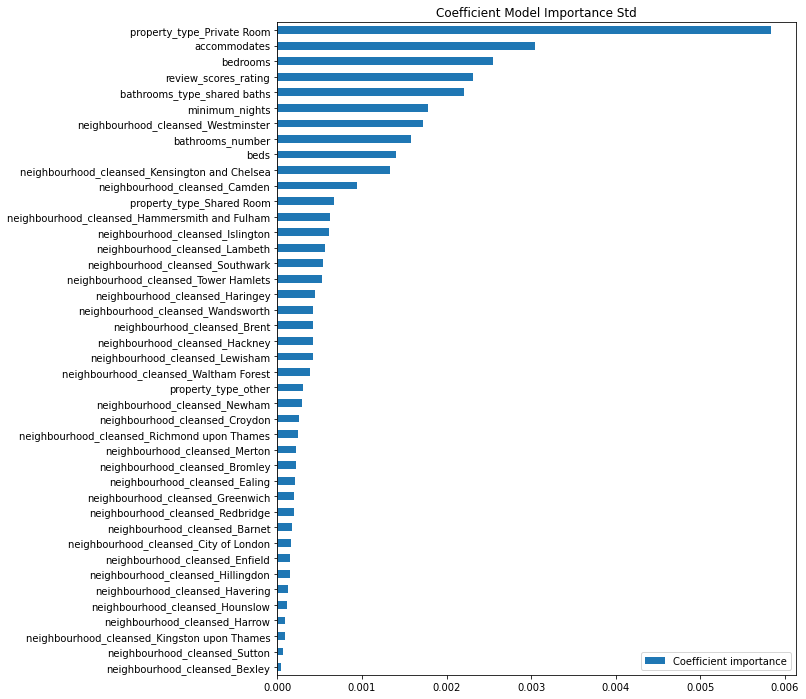

In [41]:
# Looking at the importante standard deviation - to see if a small change in the factor will change the predictions a lot (if this is the case this indicates this parameter is important)
r = permutation_importance(rf, X_test, y_test,n_repeats=30,random_state=0)
coefs_imp = pd.DataFrame(r["importances_std"],columns=['Coefficient importance'], index=X_train.columns)

coefs_imp=coefs_imp.sort_values('Coefficient importance', ascending=True)

coefs_imp.plot(kind='barh', figsize=(12, 12))
plt.title('Coefficient Model Importance Std')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# Appendix

### Outlier identification and removal: Method that was tried but not used in the end



In [ ]:
# Looking at the standard deviation:
# create a scaler object
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
df_std = pd.DataFrame(std_scaler.fit_transform(features_final), columns=features_final.columns)
df_std

,price,review_scores_rating,accommodates,bedrooms,beds,minimum_nights,maximum_nights,bathrooms_number,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Private Room,property_type_Shared Room,property_type_other,bathrooms_type_shared baths,instant_bookable_t
0,-0.028019,-0.230253,0.425347,-0.571639,0.997337,0.112829,-0.006165,-0.516416,-0.136962,-0.054968,-0.173571,-0.088779,-0.274734,-0.06936,-0.115951,-0.14937,-0.0917,-0.145843,-0.290620,-0.224147,-0.169753,-0.07304,-0.057467,-0.091034,-0.116656,-0.255997,-0.258641,-0.084813,3.874261,-0.174605,-0.126377,-0.155199,-0.088665,-0.126295,-0.25582,-0.060366,-0.312665,-0.135137,-0.234367,-0.340174,-0.845944,-0.076414,-0.122156,-0.604462,1.308289
1,-0.187283,0.364710,-0.602733,-0.571639,-1.384365,-0.171424,-0.006197,-0.516416,-0.136962,-0.054968,-0.173571,-0.088779,-0.274734,-0.06936,-0.115951,-0.14937,-0.0917,-0.145843,-0.290620,-0.224147,-0.169753,-0.07304,-0.057467,-0.091034,-0.116656,3.906298,-0.258641,-0.084813,-0.258114,-0.174605,-0.126377,-0.155199,-0.088665,-0.126295,-0.25582,-0.060366,-0.312665,-0.135137,-0.234367,-0.340174,1.182112,-0.076414,-0.122156,1.654363,-0.764357
2,-0.089489,0.265550,-0.602733,-0.571639,-0.590465,0.254956,-0.006192,-0.516416,-0.136962,-0.054968,-0.173571,-0.088779,-0.274734,-0.06936,-0.115951,-0.14937,-0.0917,-0.145843,-0.290620,-0.224147,-0.169753,-0.07304,-0.057467,-0.091034,-0.116656,-0.255997,3.866365,-0.084813,-0.258114,-0.174605,-0.126377,-0.155199,-0.088665,-0.126295,-0.25582,-0.060366,-0.312665,-0.135137,-0.234367,-0.340174,-0.845944,-0.076414,-0.122156,-0.604462,1.308289
3,0.558745,0.067229,1.453426,1.815742,0.997337,-0.029298,-0.006130,1.141533,-0.136962,-0.054968,-0.173571,-0.088779,-0.274734,-0.06936,-0.115951,-0.14937,-0.0917,-0.145843,-0.290620,-0.224147,-0.169753,-0.07304,-0.057467,-0.091034,-0.116656,-0.255997,-0.258641,-0.084813,-0.258114,-0.174605,-0.126377,-0.155199,-0.088665,-0.126295,-0.25582,-0.060366,-0.312665,-0.135137,-0.234367,2.939670,-0.845944,-0.076414,-0.122156,-0.604462,-0.764357
4,-0.218019,0.265550,-0.602733,-0.571639,-1.384365,0.254956,-0.005980,0.312559,7.301286,-0.054968,-0.173571,-0.088779,-0.274734,-0.06936,-0.115951,-0.14937,-0.0917,-0.145843,-0.290620,-0.224147,-0.169753,-0.07304,-0.057467,-0.091034,-0.116656,-0.255997,-0.258641,-0.084813,-0.258114,-0.174605,-0.126377,-0.155199,-0.088665,-0.126295,-0.25582,-0.060366,-0.312665,-0.135137,-0.234367,-0.340174,1.182112,-0.076414,-0.122156,1.654363,1.308289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50122,-0.187283,0.662192,-0.602733,-0.571639,-0.590465,-0.171424,-0.005979,2.799483,-0.136962,-0.054968,-0.173571,-0.088779,-0.274734,-0.06936,-0.115951,-0.14937,-0.0917,-0.145843,-0.290620,-0.224147,-0.169753,-0.07304,-0.057467,-0.091034,-0.116656,-0.255997,-0.258641,-0.084813,-0.258114,5.727223,-0.126377,-0.

In [ ]:
# apply the robust scaling in Pandas using the .median() and .quantile() methods
def robust_scaling(df):
    # copy the dataframe
    df_robust = df.copy()
    # apply robust scaling
    for column in df_robust.columns:
        df_robust[column] = (df_robust[column] - df_robust[column].median())  / (df_robust[column].quantile(0.75) - df_robust[column].quantile(0.25))
    return df_robust

# call the robust_scaling function
#features_final_robust = robust_scaling(features_final.price)
df_robust = features_final.copy()
#column = "price"
#df_robust[column] =  (df_robust[column] - df_robust[column].median())  / (df_robust[column].quantile(0.75) - df_robust[column].quantile(0.25))
column = "maximum_nights"
df_robust[column] =  (df_robust[column] - df_robust[column].median())  / (df_robust[column].quantile(0.75) - df_robust[column].quantile(0.25))
column = "minimum_nights"
df_robust[column] =  (df_robust[column] - df_robust[column].median())  / (df_robust[column].quantile(0.75) - df_robust[column].quantile(0.25))
df_robust

,price,review_scores_rating,accommodates,bedrooms,beds,minimum_nights,maximum_nights,bathrooms_number,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Private Room,property_type_Shared Room,property_type_other,bathrooms_type_shared baths,instant_bookable_t
0,97.0,91.0,4,1.0,3.0,2.5,-0.854662,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,40.0,97.0,2,1.0,0.0,-0.5,-1.001828,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,75.0,96.0,2,1.0,1.0,4.0,-0.982633,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,307.0,94.0,6,3.0,3.0,1.0,-0.694698,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,29.0,96.0,2,1.0,0.0,4.0,-0.004570,1.5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76412,40.0,100.0,2,1.0,1.0,-0.5,0.000000,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
76435,24.0,100.0,2,1.0,1.0,-0.5,-1.023766,1.5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
76563,150.0,100.0,4,2.0,2.0,1.0,-0.973492,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
76600,40.0,100.0,2,1.0,1.0,0.0,0.000000,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1


In [ ]:
#calculate z-scores of `df`
z_scores = stats.zscore(features_final)
#Removing values with a z score higher then 3
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
features_final_z = features_final[filtered_entries]


## Other Models

The r-squared score for the model using only quantitative variables was 0.6643369994424043 on 14985 values.


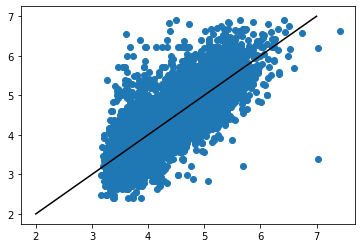

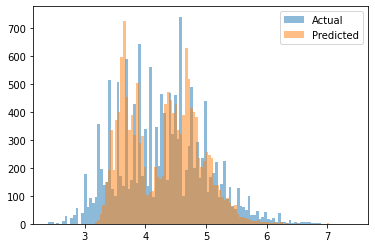

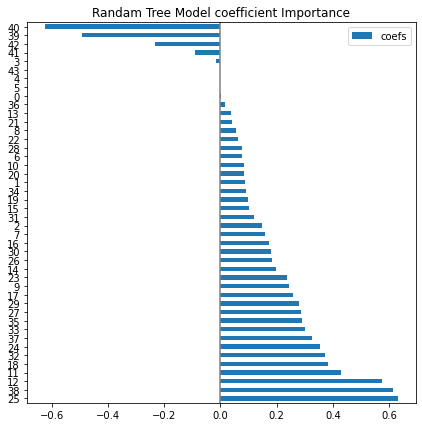

In [ ]:
################### Linear Regression #######################

#Split into explanatory and response variables
#X = pd.concat([features_final['bedrooms'],features_final["bathrooms_number"]], axis=1)
x = features_final_reduced.drop(['price'], axis=1)
y = features_final_reduced['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state=42) 


lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))

#scatter plot of the predict vs actual prices:
x_coordinates = [2, 3, 4,5,6,7]
plt.plot(x_coordinates, x_coordinates, color='black')
plt.scatter(y_test_preds, y_test)
plt.show()

plt.hist(y_test, bins=100, alpha=0.5, label='Actual')
plt.hist(y_test_preds, bins=100, alpha=0.5, label='Predicted')
plt.legend(loc='upper right')
plt.show()

coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_sorted = coefs_df.sort_values('coefs', ascending=False).head(50)
coefs_sorted.plot(kind='barh', figsize=(9, 7))
plt.title('Randam Tree Model coefficient Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

The r-squared score for the model using only quantitative variables was 0.6665461573433995 on 14985 values.


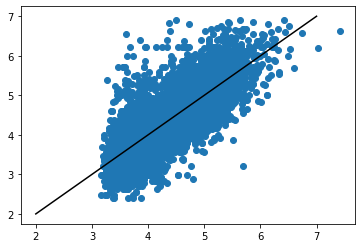

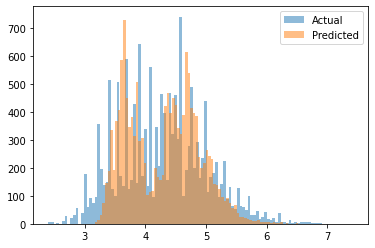

In [ ]:
################### Linear Regression #######################
################### Reducing the number of variables ########
#Split into explanatory and response variables
#X = pd.concat([features_final['bedrooms'],features_final["bathrooms_number"]], axis=1)
x_reduced = features_final_reduced.drop(['price',"maximum_nights","instant_bookable_t" ], axis=1)
y_reduced = features_final_reduced['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(x_reduced, y_reduced, test_size = .3, random_state=42) 
 
lm_model = LinearRegression(normalize=False) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
#Predict and score the model
y_test_preds_reduced = lm_model.predict(X_test) 
print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds_reduced), len(y_test)))

x_coordinates = [2, 3, 4,5,6,7]
plt.plot(x_coordinates, x_coordinates, color='black')
plt.scatter(y_test_preds_reduced, y_test)
plt.show()

#scatter plot of the predict vs actual prices:
plt.hist(y_test, bins=100, alpha=0.5, label='Actual')
plt.hist(y_test_preds_reduced, bins=100, alpha=0.5, label='Predicted')
plt.legend(loc='upper right')
plt.show()

In [ ]:
################### Decision Tree Regression #######################
#Split into explanatory and response variables
#X = pd.concat([features_final['bedrooms'],features_final["bathrooms_number"]], axis=1)
x_reduced = features_final_reduced.drop(['price',"maximum_nights","instant_bookable_t" ], axis=1)
y_reduced = features_final_reduced['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(x_reduced, y_reduced, test_size = .3, random_state=42) 


regressor = DecisionTreeRegressor(random_state = 42)

regressor.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = regressor.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.5039555629072289 on 14985 values.'

In [ ]:
# Standard deviation code 
# coefs_x_std = X_train_SD*coefs['coefs'].values
# coefs_x_std_sorted = coefs_x_std.sort_values()
# print(coefs_x_std_sorted)

# coefs_x_std_sorted.plot(kind='barh', figsize=(12, 12))
# plt.title('Ridge model, small regularization')
# plt.axvline(x=0, color='.5')
# plt.subplots_adjust(left=.3)